**Подключение библиотек и скриптов**

In [155]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [156]:
import warnings
warnings.filterwarnings('ignore')

In [157]:
matplotlib.rcParams.update({'font.size': 14})

In [158]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Функция оценивает результаты предсказания
    
    Parameters: 
        train_true_values, 
        train_pred_values, 
        test_true_values, 
        test_pred_values

    # Returns

    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [159]:
def transform_with_quantile(df, field):
    """
        
    """
    max_value = np.quantile(df[field], q=0.975)
    min_value = np.quantile(df[field], q=0.025)
    condition = (df[field] > max_value) | (df[field] < min_value)
    df.loc[condition, field] = df[field].median()

**Пути к директориям и файлам**

In [160]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

MODEL_PATH_FILE = './model.pkl'
PREDICT_TARGET = './EYaromich_predictions.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [161]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Приведение типов

In [162]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [163]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [164]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

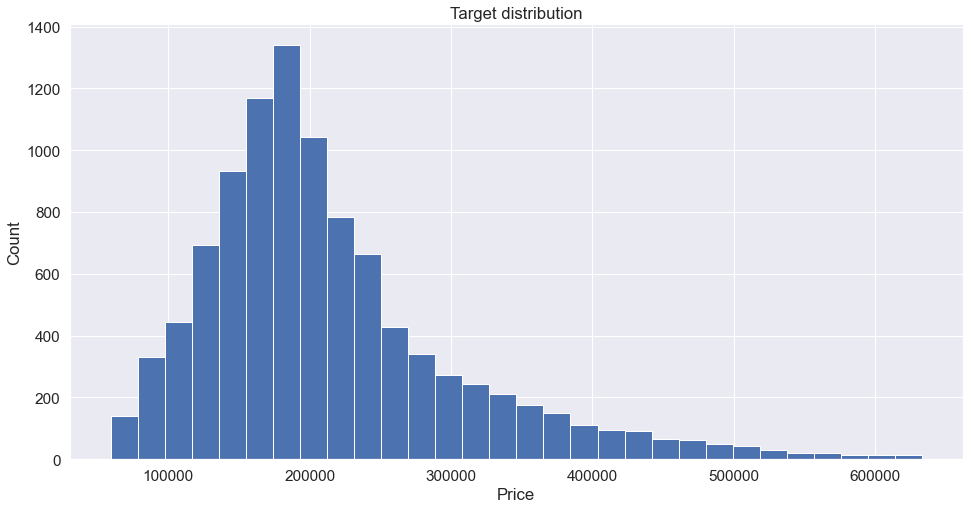

In [165]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [166]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Категориальные переменные**

In [167]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [168]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

**Rooms**

In [169]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [170]:
train_df['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [171]:
# потом добавим новый признак связанные с квартирой студией 
mask = (train_df.Rooms == 0) & (train_df.KitchenSquare == 0)
train_df.loc[mask, 'Rooms'] = 1
train_df.loc[train_df.Rooms == 0]

#остальное оставим как выбрасы
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [172]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888100,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812431,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [173]:
train_df["LifeSquare"].isnull().sum()

2113

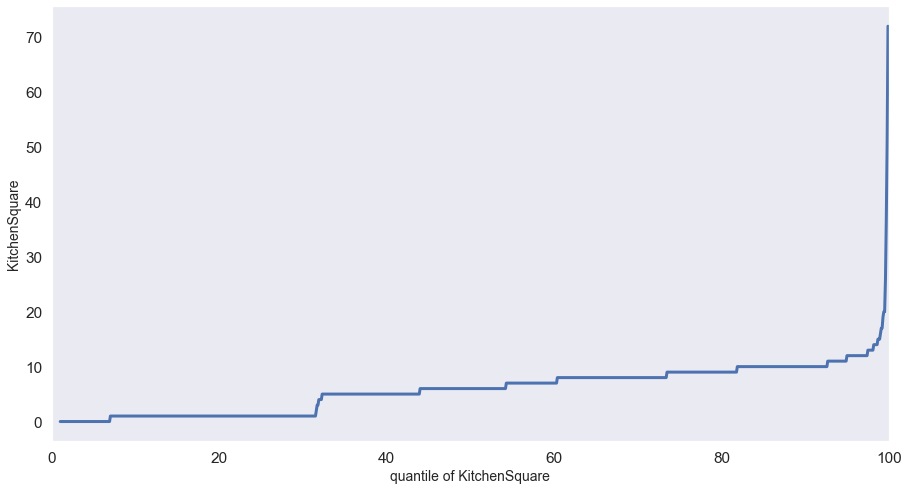

In [174]:
fig = plt.figure(figsize=(15, 8))
q = [np.percentile(train_df["KitchenSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of KitchenSquare", size=14)
plt.ylabel("KitchenSquare", size=14)
plt.xlim(0, 100)
plt.grid()

In [175]:
# преобразуем KitchenSquare, путем замены выбрасов медианой
transform_with_quantile(train_df, 'KitchenSquare')

# пропуски и выбрасы lifeSquare заполним путем Square - KitchenSquare
mask = (train_df.LifeSquare.isna()) | (train_df.LifeSquare > train_df.Square)
train_df.loc[mask, 'LifeSquare'] = train_df.loc[mask, 'Square'] - train_df.loc[mask, 'KitchenSquare']

train_df["LifeSquare"].isnull().sum()

0

In [176]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888100,56.315775,40.765465,5.536700,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812431,21.058732,22.154538,3.670668,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.136859,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,25.443690,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,36.742342,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,49.570450,8.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,638.163193,13.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [177]:
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.167877
69,6925,27,2.0,64.929103,63.304605,10.0,15,17.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,228584.001072
129,6072,6,1.0,65.102017,64.622603,1.0,10,9.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,175899.978284
136,6172,27,2.0,92.400007,92.069236,10.0,2,5.0,1977,0.075424,B,B,11,3097,0,NaN,0,0,B,116942.671045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9860,15304,124,1.0,45.220099,44.240841,13.0,12,12.0,1974,0.122090,B,B,29,6566,7,1894.0,4,0,B,180351.773573
9874,10318,6,1.0,40.631541,38.750052,7.0,5,17.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,131271.924425
9897,4497,1,1.0,38.330353,38.010046,8.0,7,17.0,1991,0.025609,B,B,33,5261,0,240.0,3,1,B,97464.327338
9918,14904,34,4.0,104.049130,99.788387,10.0,8,25.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,411971.106869


In [178]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = train_df.LifeSquare.median()

In [179]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = train_df.KitchenSquare.median()

In [180]:
train_df.loc[mask, 'Square'] = train_df.loc[mask, "KitchenSquare"] + train_df.loc[mask, "LifeSquare"]
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask].shape[0]

2763

In [181]:
train_df.Square

0       47.981561
1       65.683640
2       44.947953
3       61.731512
4       39.649192
          ...    
9995    50.401785
9996    41.521546
9997    47.939008
9998    43.602562
9999    38.666645
Name: Square, Length: 10000, dtype: float64

**HouseFloor, Floor**

In [182]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [183]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [184]:
# train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

# значение HouseFloor не должно быть меньше Floor
mask = train_df.HouseFloor == 0

train_df.loc[mask, 'HouseFloor'] = train_df.loc[mask, 'Floor'].apply(
    lambda x: random.randint(x, round(x * 2)))

train_df['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        35.,  36.,  37.,  38.,  39.,  40.,  42.,  44.,  45.,  47.,  48.,
        99., 117.])

In [185]:
floor_delta_housefloor = train_df['HouseFloor'] - train_df['Floor']
floor_delta_housefloor = np.abs(floor_delta_housefloor[floor_delta_housefloor<0])
floor_delta_housefloor.value_counts().sort_index()

1.0     693
2.0     412
3.0      50
4.0      46
5.0      33
6.0      41
7.0      26
8.0      26
9.0      31
10.0     29
11.0     25
12.0     22
13.0     21
14.0     16
15.0     20
16.0     14
17.0      9
18.0      3
19.0      7
20.0      9
21.0      5
22.0      2
23.0      7
24.0      4
25.0      3
26.0      1
27.0      1
dtype: int64

In [186]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)
# заменим на константу -> слишком много одинаковых значений -> модель слишком сильно настроиться на это значение

**HouseYear**

In [187]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [188]:
current_year = datetime.datetime.now().year
train_df.loc[train_df.HouseYear > current_year, 'HouseYear'] = train_df.HouseYear.median()

### Обработка пропусков

In [189]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [190]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,6.0
3,61.731512,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
7,80.312926,80.312926,6.0
8,64.511437,63.511437,6.0
9,46.461409,18.915552,8.0


In [191]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

9.345799381360823

In [192]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

**Healthcare_1**

In [193]:
train_df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [194]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [195]:
dh = train_df.groupby(['DistrictId']).agg({'Healthcare_1':'median'}).dropna().rename(columns={'Healthcare_1':'DistrictHealthcare'})

train_df = train_df.merge(dh, on=['DistrictId'], how='left')

mask = (train_df.Healthcare_1.isna()) & (~train_df.DistrictHealthcare.isna())
train_df.loc[mask, 'Healthcare_1'] = train_df.loc[mask, 'DistrictHealthcare']

train_df.drop(columns='DistrictHealthcare', inplace=True)

train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     1884
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [196]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = 9

### Построение новых признаков


**Mean_Square_by_room, diff_square_and_mean_square_by_rooms, ratio_square_and_mean_square_by_rooms, bigger_then_mean**

In [197]:
gp = train_df.groupby(["Rooms"])["Square"].mean()
train_df["Mean_Square_by_rooms"] = train_df["Rooms"].map(gp.to_dict())

train_df["diff_square_and_mean_square_by_rooms"] = train_df["Square"] - train_df["Mean_Square_by_rooms"]
train_df["ratio_square_and_mean_square_by_rooms"] = train_df["Square"] / train_df["Mean_Square_by_rooms"] - 1
train_df.head(n=2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.08904,...,7976,5,9.0,0,11,B,184966.930730,56.951480,-8.969919,-0.157501
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.00007,...,10309,1,240.0,1,16,B,300009.450063,77.104323,-11.420683,-0.148120


In [198]:
train_df["bigger_then_mean"] = np.where(
    train_df["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

In [199]:
train_df.groupby(["bigger_then_mean"])["Price"].mean()

bigger_then_mean
0    199932.224751
1    231272.689449
Name: Price, dtype: float64

**DistrictYear, IsDistrictOld**

In [200]:
district_year_old = train_df.groupby(['DistrictId']).agg({'HouseYear':'mean'}).rename(columns={'HouseYear':'DistrictYear'})

train_df = train_df.merge(district_year_old, on=['DistrictId'], how='left')
train_df.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.08904,...,9.0,0,11,B,184966.930730,56.951480,-8.969919,-0.157501,0,1980.545455
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.00007,...,240.0,1,16,B,300009.450063,77.104323,-11.420683,-0.148120,0,1983.528736


In [201]:
train_df.DistrictYear.describe()

count    10000.000000
mean      1984.863800
std          8.871737
min       1924.500000
25%       1978.991071
50%       1985.463415
75%       1990.818004
max       2007.000000
Name: DistrictYear, dtype: float64

In [202]:
train_df['isDistrictOld'] = np.where(train_df["DistrictYear"] > 1950, 0, 1)
train_df.groupby(["isDistrictOld"])["Price"].mean()

isDistrictOld
0    213879.857280
1    398879.942121
Name: Price, dtype: float64

**Dummies**

In [203]:
train_df["Ecology_2"]

0       B
1       B
2       B
3       B
4       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 10000, dtype: object

In [204]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictHouseToll**

In [205]:
#Введем новый признак средняя этажность на районе
district_house_toll = train_df.groupby(['DistrictId']).agg({'HouseFloor':'median'}).rename(columns={'HouseFloor':'DistrictHouseToll'})

train_df = train_df.merge(district_house_toll, on=['DistrictId'], how='left')

In [206]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictYear,isDistrictOld,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictHouseToll
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,56.951480,-8.969919,-0.157501,0,1980.545455,0,1,1,1,11.0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,77.104323,-11.420683,-0.148120,0,1983.528736,0,1,1,1,12.0
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968.0,0.049637,...,56.951480,-12.003527,-0.210768,0,1991.522989,0,1,1,1,16.0
3,5809,58,2.0,61.731512,52.731512,9.0,8,17.0,1977.0,0.437885,...,56.951480,4.780032,0.083932,1,1984.681564,0,1,1,1,12.0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,41.697585,-2.048393,-0.049125,0,1976.783505,0,1,1,1,9.0


**DistrictSize, IsDistrictLarge**

In [207]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictYear,isDistrictOld,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictHouseToll
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,56.951480,-8.969919,-0.157501,0,1980.545455,0,1,1,1,11.0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,77.104323,-11.420683,-0.148120,0,1983.528736,0,1,1,1,12.0
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968.0,0.049637,...,56.951480,-12.003527,-0.210768,0,1991.522989,0,1,1,1,16.0
3,5809,58,2.0,61.731512,52.731512,9.0,8,17.0,1977.0,0.437885,...,56.951480,4.780032,0.083932,1,1984.681564,0,1,1,1,12.0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,41.697585,-2.048393,-0.049125,0,1976.783505,0,1,1,1,9.0


In [208]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [209]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictYear,isDistrictOld,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictHouseToll,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,-8.969919,-0.157501,0,1980.545455,0,1,1,1,11.0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,-11.420683,-0.148120,0,1983.528736,0,1,1,1,12.0,87
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968.0,0.049637,...,-12.003527,-0.210768,0,1991.522989,0,1,1,1,16.0,174
3,5809,58,2.0,61.731512,52.731512,9.0,8,17.0,1977.0,0.437885,...,4.780032,0.083932,1,1984.681564,0,1,1,1,12.0,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,-2.048393,-0.049125,0,1976.783505,0,1,1,1,9.0,97


In [210]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [211]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

Text(0, 0.5, 'Price')

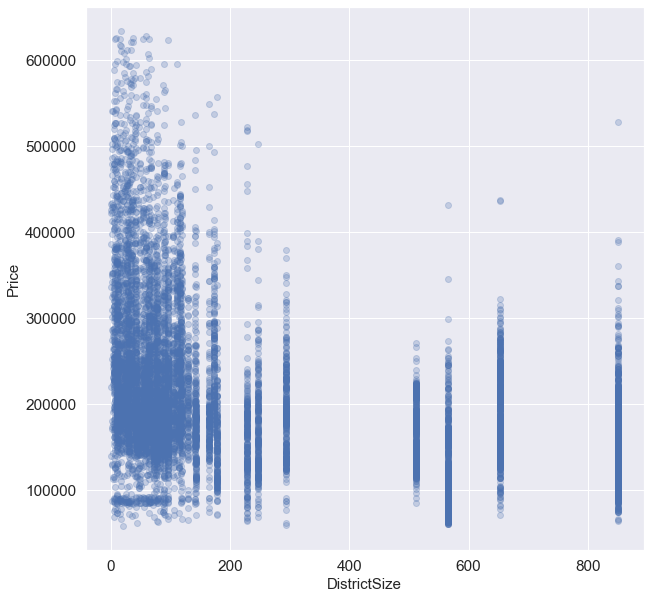

In [212]:
plt.figure(figsize=(10, 10))
plt.scatter(
    train_df["DistrictSize"], train_df["Price"], alpha=0.25
)
plt.xlabel("DistrictSize", size=15)
plt.ylabel("Price", size=15)

**MedPriceByDistrict**

In [213]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [214]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,bigger_then_mean,DistrictYear,isDistrictOld,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictHouseToll,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,0,1980.545455,0,1,1,1,11.0,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,0,1983.528736,0,1,1,1,12.0,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968.0,0.049637,...,0,1991.522989,0,1,1,1,16.0,174,1,263206.223152
3,5809,58,2.0,61.731512,52.731512,9.0,8,17.0,1977.0,0.437885,...,1,1984.681564,0,1,1,1,12.0,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,0,1976.783505,0,1,1,1,9.0,97,0,158539.052715


**is_studia_flat**

In [215]:
# train_df['is_studia_flat'] = 0
# train_df.loc[train_df.KitchenSquare < 2, 'is_studia_flat'] = 1
# train_df.groupby("is_studia_flat").Price.mean()

**isLastFloor**

In [216]:
train_df['isLastFloor'] = 0
train_df.loc[train_df.Floor == train_df.HouseFloor, 'isLastFloor'] = 1
train_df.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictYear,isDistrictOld,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictHouseToll,DistrictSize,IsDistrictLarge,MedPriceByDistrict,isLastFloor
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.08904,...,1980.545455,0,1,1,1,11.0,22,0,207786.135836,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.00007,...,1983.528736,0,1,1,1,12.0,87,0,300009.450063,0


**isFirsFloor**

In [217]:
train_df['isFirstFloor'] = 0
train_df.loc[train_df.Floor == 1, 'isFirstFloor'] = 1
train_df.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,isDistrictOld,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictHouseToll,DistrictSize,IsDistrictLarge,MedPriceByDistrict,isLastFloor,isFirstFloor
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.08904,...,0,1,1,1,11.0,22,0,207786.135836,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.00007,...,0,1,1,1,12.0,87,0,300009.450063,0,0


**HaveStoke**

In [218]:
train_df['StokeSquare'] = train_df['Square'] - train_df['LifeSquare'] - train_df['KitchenSquare']
train_df.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictHouseToll,DistrictSize,IsDistrictLarge,MedPriceByDistrict,isLastFloor,isFirstFloor,StokeSquare
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.08904,...,1,1,1,11.0,22,0,207786.135836,0,0,12.538811
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.00007,...,1,1,1,12.0,87,0,300009.450063,0,0,17.634097


**Roms_vc**

In [219]:
train_df["Rooms_vc"] = train_df["Rooms"].map(train_df["Rooms"].value_counts().to_dict())

**Floor_vc**

In [220]:
train_df["Floor_vc"] = train_df["Floor"].map(train_df["Floor"].value_counts().to_dict())

### Общий вид параметров

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>],
       [<AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Mean_Square_by_rooms'}>,
        <AxesSubplot:title={'center':'diff_square_and_mean_square_by_rooms'}>,
        <AxesSubplot:title={'center':'ratio_square_and_mean_square_by_rooms'}>],
    

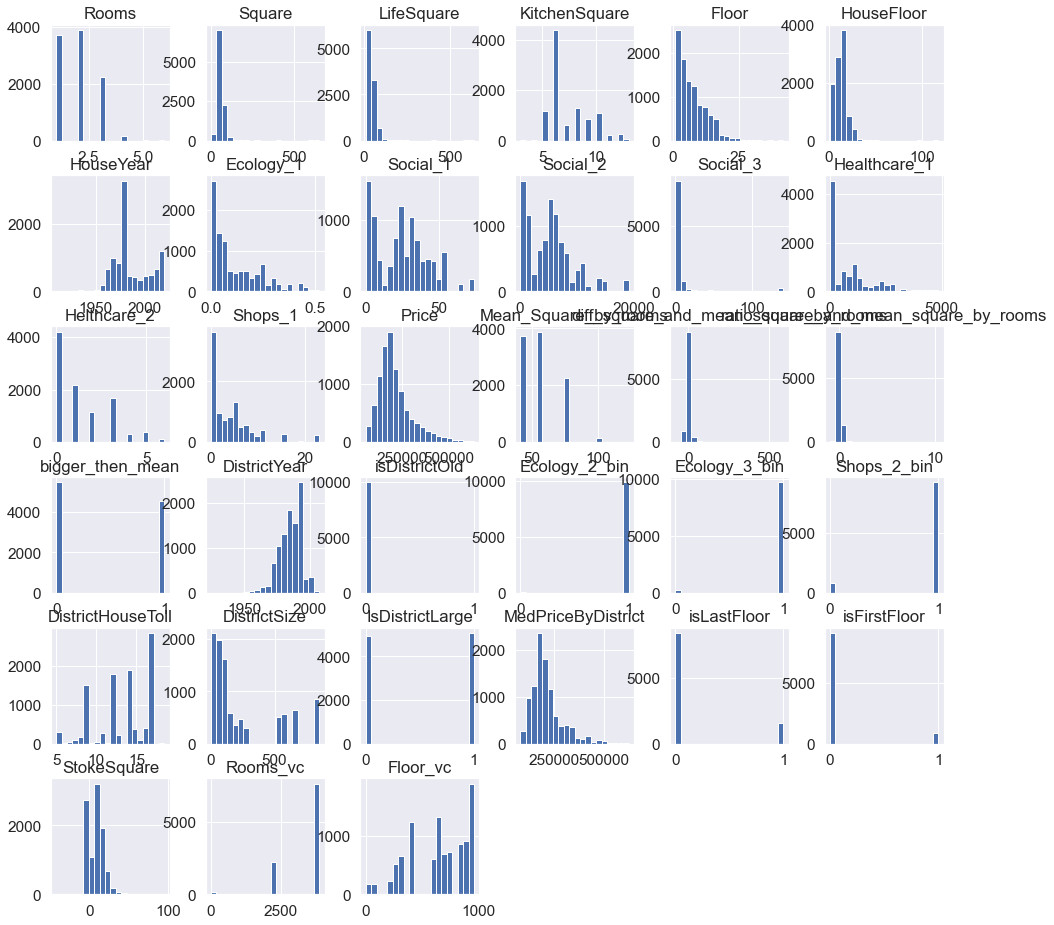

In [221]:
train_df.hist(bins=20, figsize=(16, 16))

### Матрица кореляции 

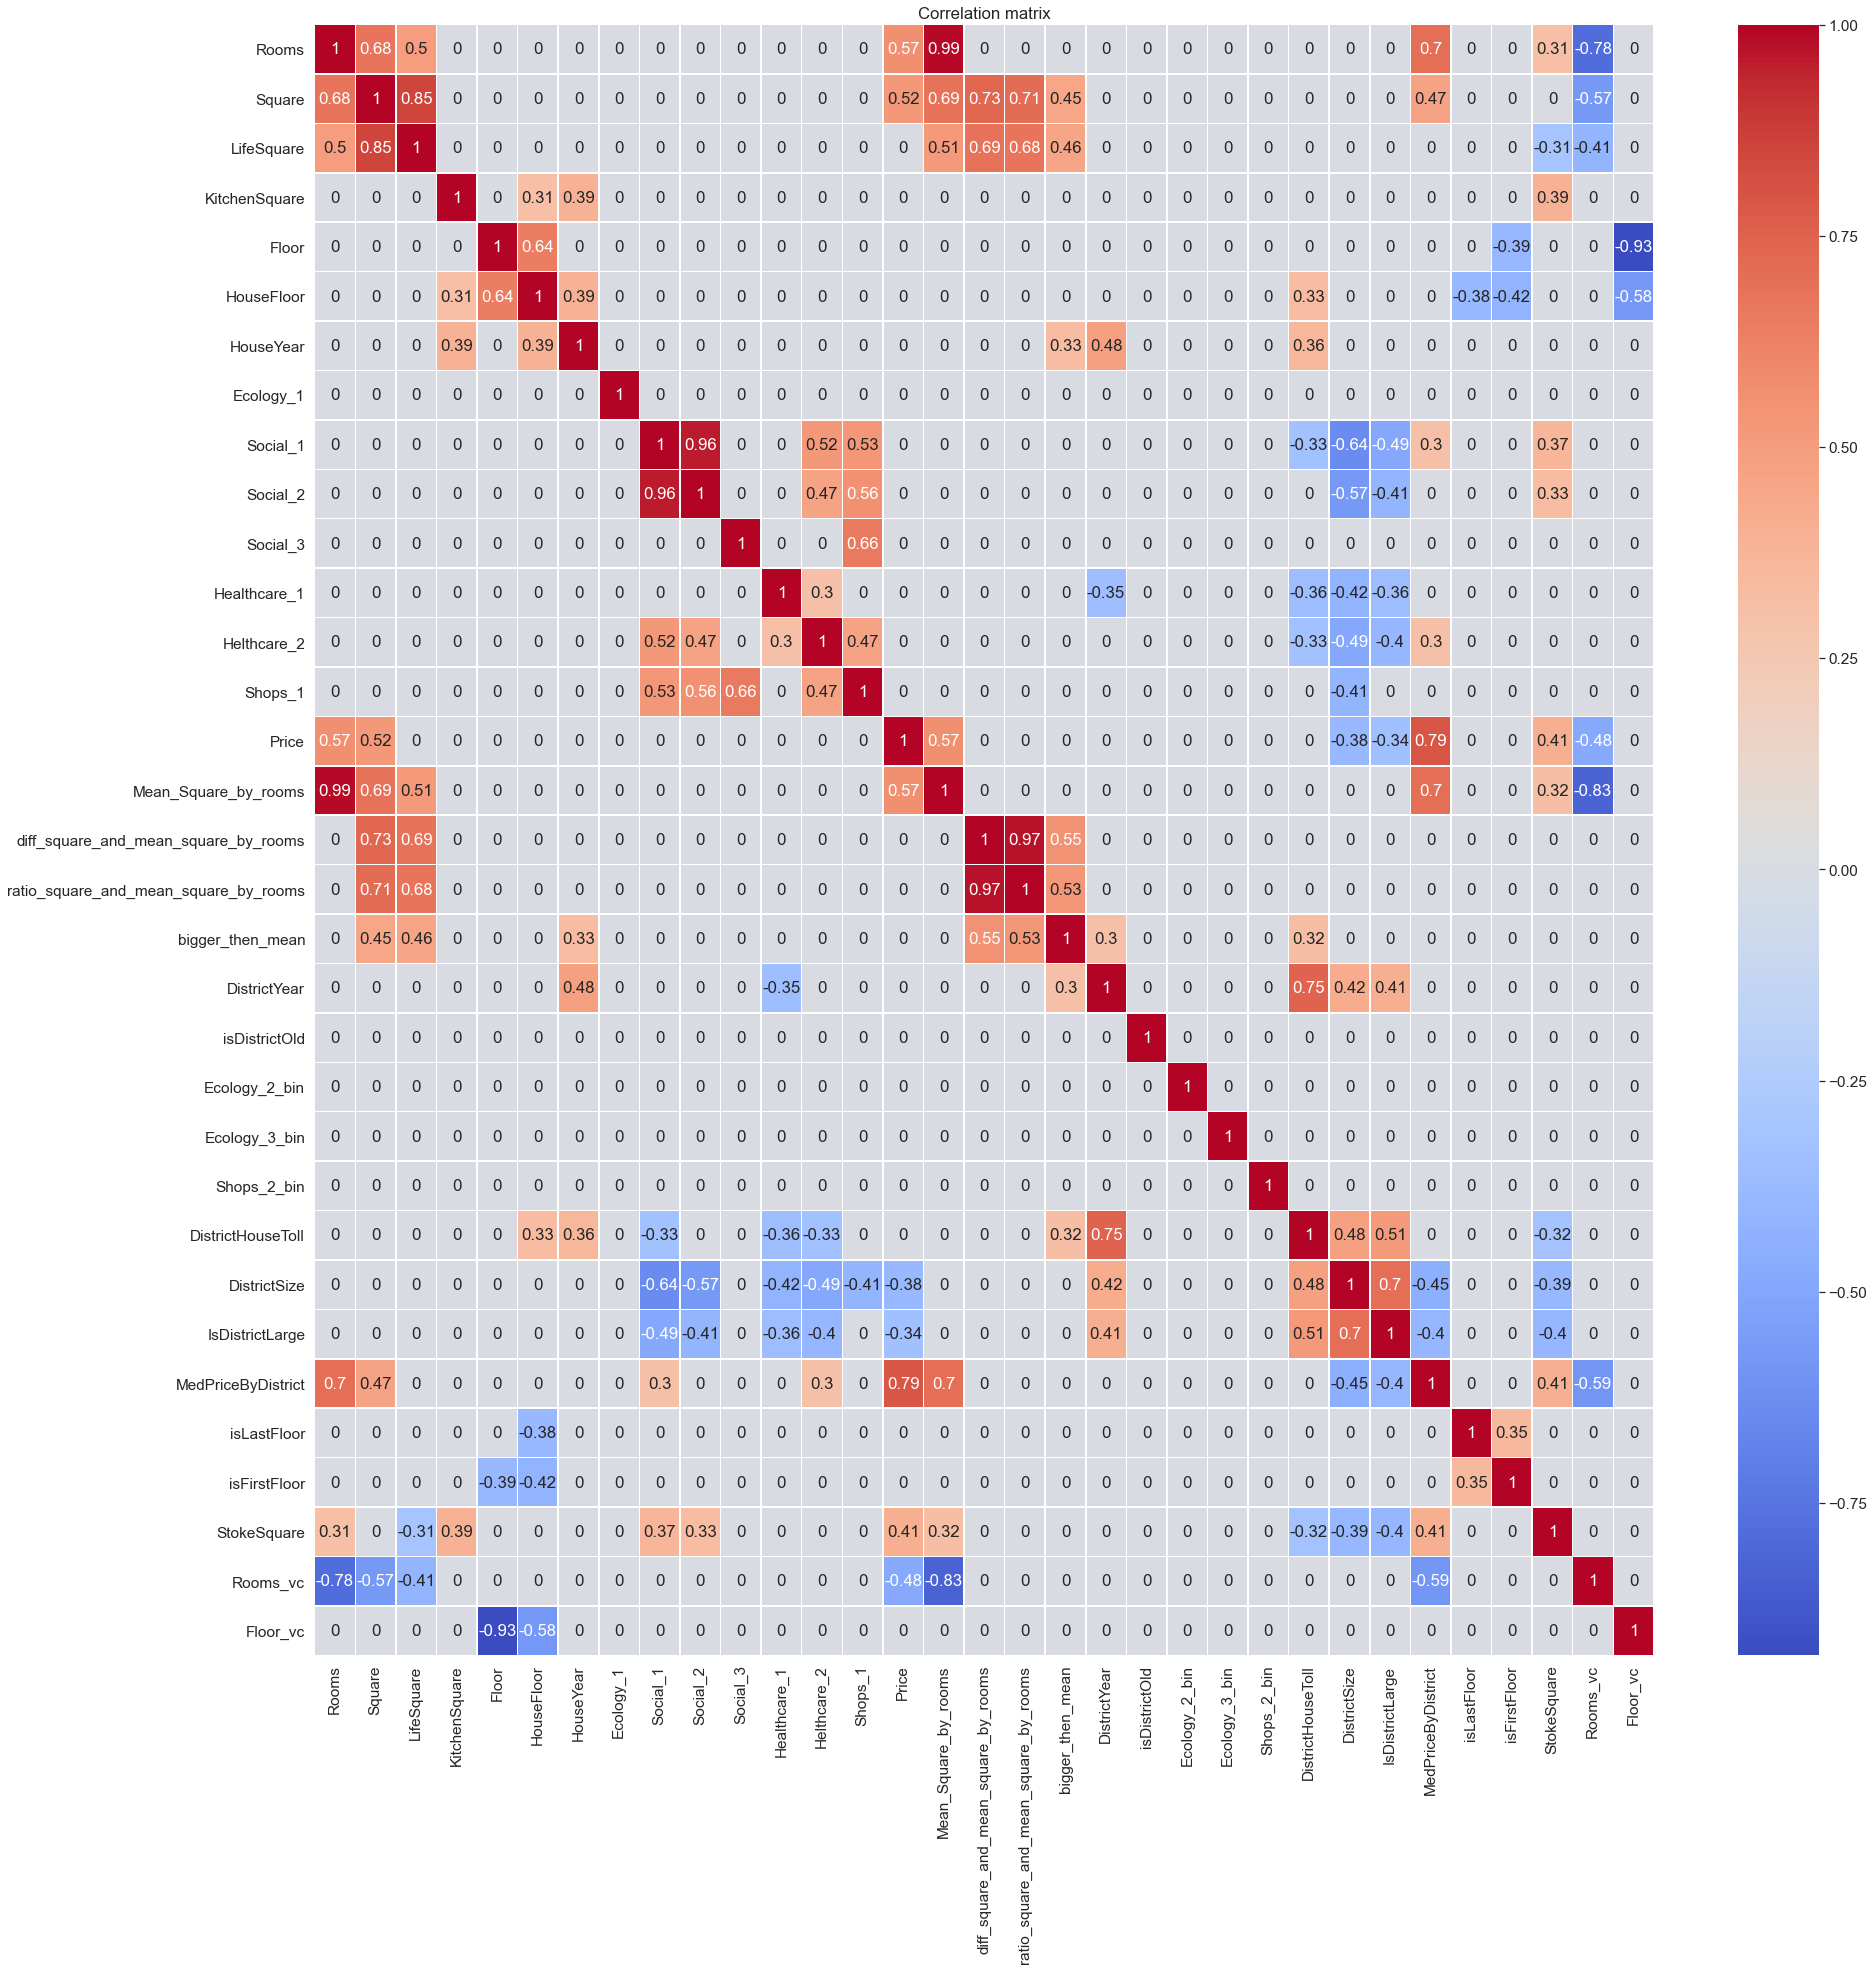

In [222]:
plt.figure(figsize = (30,30))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [223]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms',
 'ratio_square_and_mean_square_by_rooms',
 'bigger_then_mean',
 'DistrictYear',
 'isDistrictOld',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictHouseToll',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'isLastFloor',
 'isFirstFloor',
 'StokeSquare',
 'Rooms_vc',
 'Floor_vc']

In [224]:
feature_names = [
    'Rooms', 
    'Square', 
    'LifeSquare', 
    'KitchenSquare', 
    'Floor', 
    'HouseFloor', 
    'HouseYear',
    'Ecology_1', 
    'Ecology_2_bin', 
    'Ecology_3_bin', 
    'Social_1', 
    'Social_2', 
    'Social_3',
    'Healthcare_1', 
    'Helthcare_2', 
    'Shops_1',
    'Shops_2_bin'
]

new_feature_names = [
    'IsDistrictLarge',
    'MedPriceByDistrict',
    'DistrictHouseToll',
    'DistrictSize',
    'bigger_then_mean',
    #'isDistrictOld',
    'DistrictYear',
    'StokeSquare',
    'isLastFloor',
    'isFirstFloor',
    'Rooms_vc',
    'Floor_vc'

]
target_name = 'Price'

### Разбиение на train и test

In [225]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [226]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

### Построение модели

**Обучение и оценка модели**

In [227]:
def check_model(model, X_train, X_test, y_train, **kargs):
    print(model, '\n')
    spam_model = model(**kargs)
    spam_model.fit(X_train.fillna(-9999), y_train)
    
    y_train_preds = spam_model.predict(X_train.fillna(-9999))
    y_test_preds = spam_model.predict(X_test)

    evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)
    return spam_model

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'> 

Train R2:	0.921
Test R2:	0.76


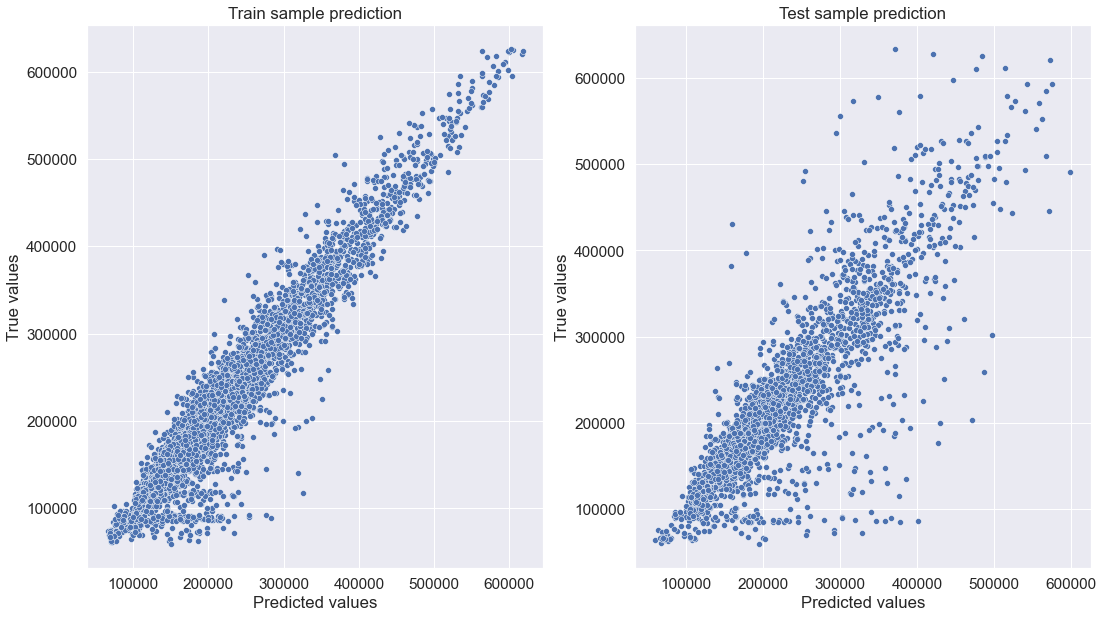

In [228]:
# rf_model = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=21)
# rf_model.fit(X_train.fillna(-9999), y_train)

#check_model(RandomForestRegressor, X_train, X_test, y_train, max_depth=9, n_estimators=400, random_state=18)
#check_model(LinearRegression, X_train, X_test, y_train)
model = check_model(GradientBoostingRegressor, X_train, X_test, y_train, max_depth=6, n_estimators=100, random_state=18)

**Подбор параметров**

In [229]:
# params = {'n_estimators':[50, 100, 200, 400],

#           'max_depth': np.arange(5, 10)}

# gs = GridSearchCV(
#     model, 
#     params, 
#     scoring='r2', 
#     cv=KFold(n_splits=3, random_state=17, shuffle=True),
#     n_jobs=-1
# )
# gs.fit(X, y)

In [230]:
# len(X_train.columns)

In [231]:
# gs.best_params_

In [232]:
# gs.best_score_

**Перекрёстная проверка**

In [233]:
from sklearn.model_selection import StratifiedKFold

In [234]:
cv_score = cross_val_score(
    model,
    X.fillna(-9999),
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=17)
)
cv_score

array([0.74480603, 0.76730642, 0.79543922, 0.75301319, 0.76797822])

In [235]:
cv_score.mean(), cv_score.std()

(0.7657086178265804, 0.017260967109147547)

In [236]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7484476507174328, 0.782969584935728)

**Важность признаков**

In [237]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.649706
1,Square,0.104375
23,StokeSquare,0.032932
22,DistrictYear,0.023328
6,HouseYear,0.022172
2,LifeSquare,0.021281
5,HouseFloor,0.017197
12,Social_3,0.015715
3,KitchenSquare,0.012972
11,Social_2,0.012911


### Преобразования тестовых значений

### DataPipeLine

In [238]:
class DataPipeLine:
    
    def __init__(self):
        """Параметры класса"""
        self.LifeSquare_median = None
        self.KitchenSquare_median = None
        self.HouseYear_median = None
        self.med_price_by_district = pd.DataFrame()
    
    def __transform_with_quantile(df, field):
        """Преобразование данных при помощи квантилей, максимальное значение соответствует 0.975 квантилю, 
        минимальное значение соответствует 0.025 квантилю
        
        #Parameters: 
            df - pandas.DataFrame для преобразования
            field - признак который нужно преобразовать
            
        # Returns
            преобразованный pandas.DataFrame
        """
        max_value = np.quantile(df[field], q=0.975)
        min_value = np.quantile(df[field], q=0.025)
        condition = (df[field] > max_value) | (df[field] < min_value)
        df.loc[condition, field] = df[field].median()
    
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.LifeSquare_median = df.LifeSquare.median()
        self.KitchenSquare_median = df.KitchenSquare.median()
        self.HouseYear_median = df.HouseYear.median()
        

    def transform(self, df):
        """Трансформация данных"""
        
        # Убираем из рассмотрения статистики напрямую не интересные для рассмотрения
        df['Id'] = df['Id'].astype(str)
        df['DistrictId'] = df['DistrictId'].astype(str)
        
        # 1. Выбросы (outliers)
        
        # Rooms. Комнаты с нулевым 
        
        mask = (df.Rooms == 0) & (df.KitchenSquare == 0)
        df.loc[mask, 'Rooms'] = 1
        df.loc[df.Rooms == 0]
        df.loc[df['Rooms'].isin([0, 10, 19]), 'Rooms'] = df['Rooms'].median()
        
        #Square, LifeSquare, KitchenSquare
        
        # преобразуем KitchenSquare, путем замены выбрасов медианой
        transform_with_quantile(df, 'KitchenSquare')

        # пропуски и выбрасы lifeSquare заполним путем Square - KitchenSquare
        mask = (df.LifeSquare.isna()) | (df.LifeSquare > df.Square)
        df.loc[mask, 'LifeSquare'] = df.loc[mask, 'Square'] - df.loc[mask, 'KitchenSquare']
        
        df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = self.LifeSquare_median
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = self.KitchenSquare_median
        
        # Square > KitchenSquare + LifeSquare, иначе пересчитываем
        mask = df["Square"] < df["KitchenSquare"] + df["LifeSquare"]
        df.loc[mask, 'Square'] = df.loc[mask, "KitchenSquare"] + df.loc[mask, "LifeSquare"]
        
        #HouseFloor, Floor
        
        #Убираем квартиры с 0 этажностью
        mask = df.HouseFloor == 0
        df.loc[mask, 'HouseFloor'] = df.loc[mask, 'Floor'].apply(
            lambda x: random.randint(x, round(x * 2)))
        
        # значение HouseFloor не должно быть меньше Floor
        floor_outliers = df[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(
            lambda x: random.randint(1, x)
        )
        
        #HouseYear
        
        #дома у которых год больше текущего заменяем на средний
        current_year = datetime.datetime.now().year
        df.loc[df.HouseYear > current_year, 'HouseYear'] = self.HouseYear_median
        
        # 2. Пропуски
        
        df.loc[df.LifeSquare.isna(), 'LifeSquare'] = self.LifeSquare_median
        
        #Найдем средний показатель Healthcare_1 по району и заменим его на пропуски
        dh = df.groupby(['DistrictId']).agg({'Healthcare_1':'median'}).dropna().rename(columns={'Healthcare_1':'DistrictHealthcare'})
        df = df.merge(dh, on=['DistrictId'], how='left')
        mask = (df.Healthcare_1.isna()) & (~df.DistrictHealthcare.isna())
        df.loc[mask, 'Healthcare_1'] = df.loc[mask, 'DistrictHealthcare']
        df.drop(columns='DistrictHealthcare', inplace=True)

        # остальное заменим любым числом
        df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = 9
        
        
        # 3. Новые фичи (features)
        
        #Mean_Square_by_room, diff_square_and_mean_square_by_rooms, ratio_square_and_mean_square_by_rooms, bigger_then_mean
        gp = df.groupby(["Rooms"])["Square"].mean()
        df["Mean_Square_by_rooms"] = df["Rooms"].map(gp.to_dict())
        df["diff_square_and_mean_square_by_rooms"] = df["Square"] - df["Mean_Square_by_rooms"]
        df["ratio_square_and_mean_square_by_rooms"] = df["Square"] / df["Mean_Square_by_rooms"] - 1
        df["bigger_then_mean"] = np.where(df["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)
        
        #DistrictYear, IsDistrictOld
        district_year_old = df.groupby(['DistrictId']).agg({'HouseYear':'mean'}).rename(columns={'HouseYear':'DistrictYear'})
        df = df.merge(district_year_old, on=['DistrictId'], how='left')
        df['isDistrictOld'] = np.where(df['DistrictYear'] > 1950, 0, 1)
        
        #Dummies    
        df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
        df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
        df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
        
        #DistrictHouseToll
        district_house_toll = df.groupby(['DistrictId']).agg({'HouseFloor':'median'}).rename(columns={'HouseFloor':'DistrictHouseToll'})
        df = df.merge(district_house_toll, on=['DistrictId'], how='left')
        
        #DistrictSize, IsDistrictLarge
        district_size = df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        df = df.merge(district_size, on='DistrictId', how='left')
        df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
        
        #MedPriceByDistrict
        if self.med_price_by_district.empty: 
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})
        df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        
        #isLastFloor, isFirsFloor
        df['isLastFloor'] = 0
        df.loc[df.Floor == df.HouseFloor, 'isLastFloor'] = 1
        
        df['isFirstFloor'] = 0
        df.loc[df.Floor == 1, 'isFirstFloor'] = 1
        
        #HaveStoke
        df['StokeSquare'] = df['Square'] - df['LifeSquare'] - df['KitchenSquare']
        
        #Roms_vc
        df["Rooms_vc"] = df["Rooms"].map(df["Rooms"].value_counts().to_dict())
        
        #Floor_vc
        df["Floor_vc"] = df["Floor"].map(df["Floor"].value_counts().to_dict())
        
        return df



In [239]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [240]:
pipe_liner = DataPipeLine()
pipe_liner.fit(train_df)
train_df = pipe_liner.transform(train_df)
test_df = pipe_liner.transform(test_df)

In [241]:
test_df.shape

(5000, 37)

In [242]:
# есть пропуски 
test_df.isna().sum()

Id                                        0
DistrictId                                0
Rooms                                     0
Square                                    0
LifeSquare                                0
KitchenSquare                             0
Floor                                     0
HouseFloor                                0
HouseYear                                 0
Ecology_1                                 0
Ecology_2                                 0
Ecology_3                                 0
Social_1                                  0
Social_2                                  0
Social_3                                  0
Healthcare_1                              0
Helthcare_2                               0
Shops_1                                   0
Shops_2                                   0
Mean_Square_by_rooms                      0
diff_square_and_mean_square_by_rooms      0
ratio_square_and_mean_square_by_rooms     0
bigger_then_mean                

In [243]:
test_predict = pd.DataFrame(zip(test_df.Id, 
                                       model.predict(test_df[feature_names + new_feature_names].fillna(-9999))), 
                                   columns=['Id', 'Price'])

In [245]:
test_predict.shape

(5000, 2)

In [244]:
test_predict.to_csv(PREDICT_TARGET)